# Analysis and plotting of RBD absorptions for vaccine-elicited sera

I used commercially-available magnetic beads conjugated to SARS-CoV-2 RBD to deplete serum of RBD-binding antibodies. 
This dilutes the serum 1:4 (because I added 25 uL serum + 75 uL of bead suspension at 1mg/mL). 
Depletions were performed **twice** because one round of depletion was not sufficient to deplete all RBD-binding antibodies.

The pre-depletion serum was also diluted 1:4 in PBS + 0.05% BSA. 

Depletions were performed overnight at 4C in Eppendorf tubes in a tube rotator. 

SARS-CoV-2 RBD and spike ELISAs were performed on these samples to verify the degree of RBD antibody depletion.

Here, I calculate the AUC for pre- vs. post-depletion samples and the fold-change in AUC. 

Andrea Loes then performed neutralization assays on these samples. Limit of detection is NT50 = 25.

The data that are analyzed in this notebook were pre-processed by Kate's `excel_to_fracinfect` script. 

### Set up Analysis

Import packages.

In [1]:
import itertools
import math
import os
import re
import warnings

from IPython.display import display, HTML

import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
import matplotlib.pyplot as plt
from mizani.formatters import scientific_format
import natsort

import numpy as np
import pandas as pd
from plotnine import *
import seaborn

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE
import seaborn

import lifelines
import sklearn
import scipy.stats

import yaml

In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('rbd_absorption_config.yaml') as f:
    config = yaml.safe_load(f)

Use seaborn theme and change font:

In [4]:
theme_set(theme_seaborn(style='white', context='talk', font='FreeSans', font_scale=1))
plt.style.use('seaborn-white')

In [5]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

In [6]:
pd.options.display.max_rows = 100

## Neutralization Assays

### Read in data
* Concatenate the `frac_infectivity` files.
* Remove samples specified in config file. 
* Also remove specified sample / dilution combinations where something has clearly gone wrong experimentally (like forgetting to add virus or cells). 
* Replace `serum` with `display_name`

In [7]:
sample_information = (pd.read_csv(config['sample_information'])
                      .drop_duplicates()
                     )

frac_infect = pd.DataFrame() # create empty data frame
neut_samples_ignore = config['neut_samples_ignore']

for f in config['neut_input_files'].keys():
    df = (pd.read_csv(f, index_col=0).assign(date=config['neut_input_files'][f]))
    frac_infect = frac_infect.append(df).reset_index(drop=True)

print(f"Length before dropping anything = {len(frac_infect.index)}")
    
frac_infect = (frac_infect
        .query('serum not in @neut_samples_ignore')
        #.replace({'serum' : config['display_names']})
        .reset_index(drop=True)
       )

print(f"Length after dropping neut_samples_ignore = {len(frac_infect.index)}")

frac_infect = (frac_infect
               .merge(sample_information, on='serum')
              )
frac_infect.head(2)

Length before dropping anything = 1024
Length after dropping neut_samples_ignore = 896


,serum,virus,replicate,concentration,fraction infectivity,date,day,age,dose,subject_name,mapped
0,M13-day-36,pre-depletion,1,0.04,-0.000665,210127,36,18-55y,250ug,M13,False
1,M13-day-36,pre-depletion,1,0.01,-0.000023,210127,36,18-55y,250ug,M13,False


### Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)
* Then pivot table, grouping by `serum` and keeping the `serum` and `ic50` columns
* Calculate fold-change ic50 post-depletion vs. pre-depletion
* Take fits.fitParams and drop all the pre-depletion samples 
* Keep `ic50_bound` and merge with fold_change

In [8]:
fits = neutcurve.CurveFits(frac_infect)

fitparams = (
    fits.fitParams()
    .rename(columns={'virus': 'depletion'})
    # get columns of interest
    [['serum', 'depletion', 'ic50', 'ic50_bound']]
    .assign(NT50=lambda x: 1/x['ic50'])
    .merge(sample_information, on='serum')
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)

fitparams.head(2)

,serum,depletion,ic50,ic50_bound,NT50,day,age,dose,subject_name,mapped,ic50_is_bound
0,M13-day-36,pre-depletion,0.000234,interpolated,4266.426176,36,18-55y,250ug,M13,False,False
1,M13-day-36,post-depletion,0.021151,interpolated,47.278690,36,18-55y,250ug,M13,False,False


### Make horizontal line plot connecting pre- and post-IC50
* Order with greatest fold-change at the top
* Put labels on far right with the % of neutralizing activity targeting the RBD (percent_RBD = 1-(1/foldchange))
* color by pre vs post
* shape is censored
* vertical line for limit of detection

In [9]:
foldchange = (
    fitparams
    .query('serum!="pre-pandemic"')
    .pivot_table(values='ic50', index=['serum'], columns=['depletion'])
    .reset_index()
    .rename(columns={'post-depletion': 'post-depletion_ic50', 'pre-depletion': 'pre-depletion_ic50'})
    .assign(fold_change=lambda x: x['post-depletion_ic50'] / x['pre-depletion_ic50'],
            percent_RBD= lambda x: ((1-1/x['fold_change'])*100).astype(int),
            NT50_pre=lambda x: 1/x['pre-depletion_ic50'],
            NT50_post=lambda x: 1/x['post-depletion_ic50'],
           )
    .merge(fitparams.query('depletion=="post-depletion"')[['serum', 'ic50_is_bound']], on='serum')
    .assign(perc_RBD_str = lambda x: x['percent_RBD'].astype(str)
           )
    .rename(columns={'ic50_is_bound': 'post_ic50_bound'})
    .merge(fitparams)
    )

foldchange['perc_RBD_str'] = np.where(foldchange['post_ic50_bound'], '>'+foldchange['perc_RBD_str']+'%', foldchange['perc_RBD_str']+'%')
foldchange.head(2)

,serum,post-depletion_ic50,pre-depletion_ic50,fold_change,percent_RBD,NT50_pre,NT50_post,post_ic50_bound,perc_RBD_str,depletion,ic50,ic50_bound,NT50,day,age,dose,subject_name,mapped,ic50_is_bound
0,M01-day-119,0.04,0.002663,15.018827,93,375.470679,25.0,True,>93%,pre-depletion,0.002663,interpolated,375.470679,119,18-55y,250ug,M01,True,False
1,M01-day-119,0.04,0.002663,15.018827,93,375.470679,25.0,True,>93%,post-depletion,0.040000,lower,25.000000,119,18-55y,250ug,M01,True,True


### Plot fold-change NT50 pre- and post-RBD antibody depletion for the serum samples only 
Exclude pre-pandemic serum, which was not depleted.

In [10]:
df=(foldchange
      .replace({'pre-depletion': 'pre', 'post-depletion': 'post'})
     )
df['fill_color'] = 'pre-depletion'
df.loc[df.mapped == True, 'fill_color'] = 'escape mapped'
df['fill_color'] = np.where(df['depletion'] == 'post', 'post-depletion', df['fill_color'])

df['depletion']=pd.Categorical(df['depletion'], categories=['pre', 'post'], ordered=True)

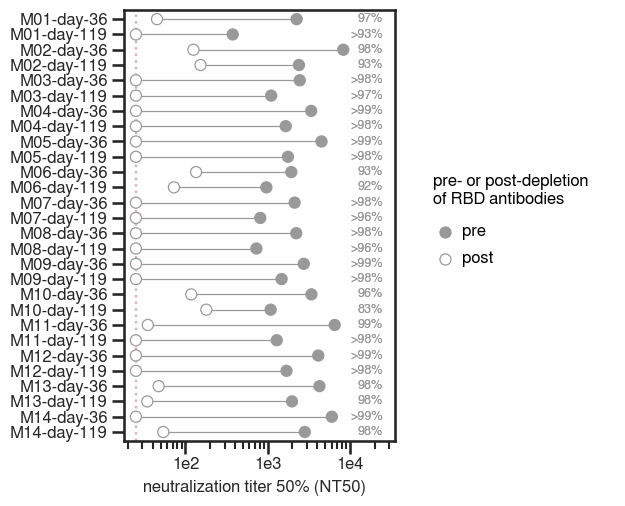

In [11]:
p = (ggplot(df
            .assign(
                    serum=lambda x: pd.Categorical(x['serum'], natsort.natsorted(x['serum'].unique())[::-1], ordered=True)
                   )
            , 
            aes(x='NT50',
                y='serum',
                fill='depletion',
                group='serum',
                label='perc_RBD_str'
               )) +
     scale_x_log10(name='neutralization titer 50% (NT50)', 
                   limits=[config['NT50_LOD'],df['NT50'].max()*3]) +
     geom_vline(xintercept=config['NT50_LOD'], 
                linetype='dotted', 
                size=1, 
                alpha=0.6, 
                color=CBPALETTE[7]) +
     geom_line(alpha=1, color=CBPALETTE[0]) +
     geom_point(size=4, color=CBPALETTE[0]) +
     geom_text(aes(x=df['NT50'].max()*3, y='serum'), #
               color=CBPALETTE[0],
               ha='right',
               size=9,
              ) +
     theme(figure_size=(3.5,0.2*df['serum'].nunique()),
           axis_text=element_text(size=12),
           legend_text=element_text(size=12),
           legend_title=element_text(size=12),
           axis_title_x=element_text(size=12),
          ) +
     ylab('') +
     scale_fill_manual(values=['#999999', '#FFFFFF', ], 
                       name='pre- or post-depletion\nof RBD antibodies')
    )

_ = p.draw()


p.save(f'{resultsdir}/NT50_lineplot_nocolors.pdf')

## Plot neut curves for all samples

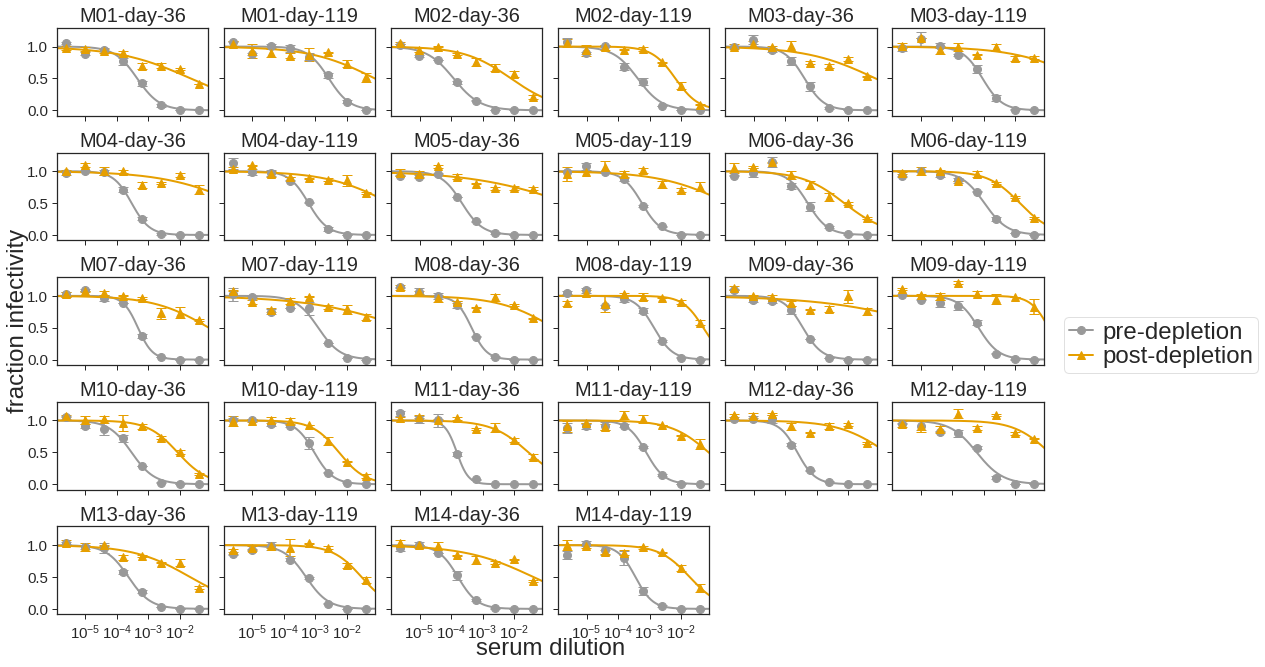

In [12]:
fig, axes = fits.plotSera(sera=natsort.natsorted(df['serum'].unique()), #+['pre-pandemic'],
                          xlabel='serum dilution',
                          ncol=6,
                          widthscale=0.8,
                          heightscale=0.8,
                          titlesize=20, labelsize=24, ticksize=15, legendfontsize=24, yticklocs=[0,0.5,1],
                          markersize=8, linewidth=2,
                         )

plotfile = PdfPages(f'{resultsdir}/sera_frac_infectivity.pdf')
plotfile.savefig(bbox_inches='tight', transparent=True)
plotfile.close()

## Compare the change in NT50 pre- vs. post-depletion for the Moderna sera vs. the HAARVI convalescent plasma

The only columns we need are:
* serum
* depletion
* NT50
* Then assign `conv_or_vax`

Concatenate the 2 dataframes. 

serum,depletion,NT50,fold_change,day,conv_or_vax,early_late
subject A (day 120),pre,861.163942,43.058197,120,convalescent,day 100-150
subject A (day 120),post,20.000000,43.058197,120,convalescent,day 100-150
subject A (day 21),pre,6881.224570,8.142050,21,convalescent,day 30-60
subject A (day 21),post,845.146407,8.142050,21,convalescent,day 30-60
subject A (day 45),pre,2751.807740,5.954031,45,convalescent,day 30-60


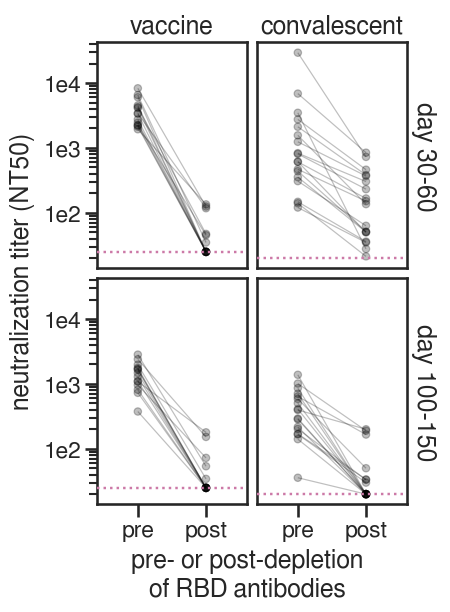

In [13]:
conv_plasma = (pd.read_csv(config['convalescent_data'])
               [['serum', 'depletion', 'NT50', 'fold_change', 'Days Post-Symptom Onset']]
               .rename(columns={'Days Post-Symptom Onset':'day'})
               .assign(conv_or_vax='convalescent')
              )

compare_df = (pd.concat([conv_plasma, 
                        (foldchange[['serum', 'depletion', 'NT50', 'fold_change', 'day']]
                         .assign(conv_or_vax='vaccine'))
                       ],
                       ignore_index=True
                      )
              .replace({'pre-depletion': 'pre', 'post-depletion':'post'})
              .assign(depletion=lambda x: pd.Categorical(x['depletion'], categories=['pre', 'post'], ordered=True), 
                      conv_or_vax=lambda x: pd.Categorical(x['conv_or_vax'], categories=['vaccine', 'convalescent'], ordered=True),
                      early_late=lambda x: x['day'].apply(lambda x: 'day 30-60' if x<=61 else 'day 100-150'),
                     )
              .assign(early_late=lambda x: pd.Categorical(x['early_late'], categories=['day 30-60', 'day 100-150'], ordered=True),)
             )
               
display(HTML(compare_df.head().to_html(index=False))) 

LOD = (pd.DataFrame(data={'conv_or_vax': ['convalescent', 'vaccine'], 'NT50': [20, 25]})
      .assign(conv_or_vax=lambda x: pd.Categorical(x['conv_or_vax'], categories=['vaccine', 'convalescent'], ordered=True))
      )

NT50_lines = (ggplot(compare_df, aes(x='depletion', y='NT50', group='serum')) +
              geom_point(size=2.5, alpha=0.25) +
              geom_line(alpha=0.25) +
              facet_grid('early_late~conv_or_vax', ) +
              theme(axis_title_y=element_text(margin={'r': 6}),
                    strip_background=element_blank(),
                    figure_size=(4, 6),) +
              scale_y_log10(name='neutralization titer (NT50)') +
              xlab('pre- or post-depletion\nof RBD antibodies') +
              geom_hline(data=LOD,
                             mapping=aes(yintercept='NT50'),
                             color=CBPALETTE[7],
                             alpha=1,
                             size=1,
                             linetype='dotted',
                            )
                 )

_ = NT50_lines.draw()
NT50_lines.save(f'./{resultsdir}/NT50_lines.pdf')

# Compare Moderna vs. convalescent change in IC50

In [14]:
haarvi = pd.read_csv(config['convalescent_data']).drop_duplicates()
moderna = (foldchange
           [['subject_name', 'day', 'serum', 'dose', 'age', 
             'pre-depletion_ic50', 'post-depletion_ic50', 'NT50_pre', 'NT50_post', 
             'fold_change','percent_RBD', 'post_ic50_bound','perc_RBD_str','mapped']]
           .drop_duplicates()
           .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
          )

df = (
    pd.concat([haarvi.assign(serum_type='convalescent')
                     .rename(columns={'Days Post-Symptom Onset': 'day',
                                      'Participant ID': 'subject_name'})
                     [['serum_type', 'fold_change', 'percent_RBD', 'post_ic50_bound', 'day', 'subject_name']]
                     .drop_duplicates(),
               moderna.assign(serum_type='vaccine')
                      [['serum_type', 'fold_change', 'percent_RBD', 'post_ic50_bound', 'day', 'subject_name']]
               ])
    )
df = pd.concat([df.sort_values('day').groupby('subject_name').first().assign(timepoint='first'),
                df.sort_values('day').groupby('subject_name').last().assign(timepoint='last')])

comparisons = list(itertools.product(df['timepoint'].unique(), df['serum_type'].unique()))
for (timepoint_1, serum_type_1), (timepoint_2, serum_type_2) in itertools.combinations(comparisons, 2):
    print(f"Comparing {timepoint_1}/{serum_type_1} to {timepoint_2}/{serum_type_2}")
    percent_1 = df.query('(timepoint == @timepoint_1) and (serum_type == @serum_type_1)')['percent_RBD']
    percent_2 = df.query('(timepoint == @timepoint_2) and (serum_type == @serum_type_2)')['percent_RBD']
    u, p = scipy.stats.mannwhitneyu(percent_1, percent_2)
    print(f"  Mann-Whitney test:      P = {p:.2g}")
    res = lifelines.statistics.logrank_test(percent_1, percent_2)
    print(f"  Log-rank test:          P = {res.p_value:.2g}")
    censored_1 = (~df.query('(timepoint == @timepoint_1) and (serum_type == @serum_type_1)')['post_ic50_bound']).astype(int)
    censored_2 = (~df.query('(timepoint == @timepoint_2) and (serum_type == @serum_type_2)')['post_ic50_bound']).astype(int)
    res = lifelines.statistics.logrank_test(percent_1, percent_2, censored_1, censored_2)
    print(f"  Log-rank test censored: P = {res.p_value:.2g}")
    # actually, Cox regression is recommended over log-rank test, see here:
    # https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html
    cox_df = pd.concat([
            pd.DataFrame({'E': censored_1, 'T': percent_1, 'groupA': 1}),
            pd.DataFrame({'E': censored_2, 'T': percent_2, 'groupA': 0})
            ])
    cph = lifelines.CoxPHFitter().fit(cox_df, 'T', 'E')
    print(f"  Cox proportional-hazards censored: P = {cph.summary.at['groupA', 'p']:.2g}")

Comparing first/convalescent to first/vaccine
  Mann-Whitney test:      P = 1.3e-05
  Log-rank test:          P = 7.9e-06
  Log-rank test censored: P = 1e-06
  Cox proportional-hazards censored: P = 1.2e-05
Comparing first/convalescent to last/convalescent
  Mann-Whitney test:      P = 0.087
  Log-rank test:          P = 0.33
  Log-rank test censored: P = 0.0074
  Cox proportional-hazards censored: P = 0.011
Comparing first/convalescent to last/vaccine
  Mann-Whitney test:      P = 0.00012
  Log-rank test:          P = 0.00049
  Log-rank test censored: P = 1.9e-05
  Cox proportional-hazards censored: P = 0.00015
Comparing first/vaccine to last/convalescent
  Mann-Whitney test:      P = 1.3e-05
  Log-rank test:          P = 3.7e-06
  Log-rank test censored: P = 0.072
  Cox proportional-hazards censored: P = 0.084
Comparing first/vaccine to last/vaccine
  Mann-Whitney test:      P = 0.0057
  Log-rank test:          P = 0.0076
  Log-rank test censored: P = 0.64
  Cox proportional-hazards 

Change to facet on time point with x-axis as serum_type

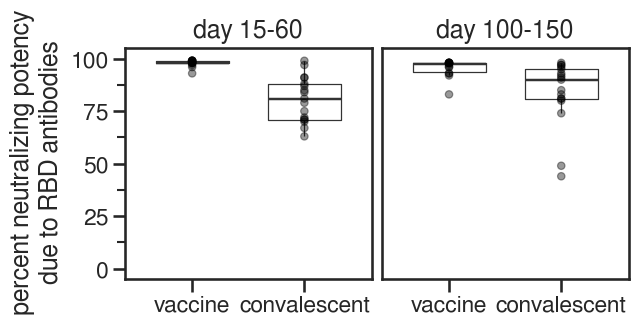

In [15]:
p = (ggplot((df.replace({"first": "day 15-60", "last": "day 100-150"})
             .assign(timepoint=lambda x: pd.Categorical(x['timepoint'], categories=['day 15-60', 'day 100-150'], ordered=True),
                     serum_type=lambda x: pd.Categorical(x['serum_type'], categories=['vaccine', 'convalescent'], ordered=True)
                    )
            )
           ) +
     aes('serum_type', 'percent_RBD') +
     geom_boxplot(width=0.65,
                  position=position_dodge(width=0.7),
                  outlier_shape='') +
     geom_jitter(position=position_dodge(width=0.7),
                 alpha=0.4, size=2.5) +
     theme(figure_size=(6.5, 3),
           strip_background=element_blank()
           ) +
     scale_y_continuous(limits=[0, 100]) +
     facet_wrap('~timepoint') +
     ylab('percent neutralizing potency\ndue to RBD antibodies') +
     xlab ('')
     )

_ = p.draw()
p.save(f'{resultsdir}/compare_percentRBD_facet.pdf')

Save `foldchange` file as Table S1.

In [16]:
foldchange.columns

Index(['serum', 'post-depletion_ic50', 'pre-depletion_ic50', 'fold_change',
       'percent_RBD', 'NT50_pre', 'NT50_post', 'post_ic50_bound',
       'perc_RBD_str', 'depletion', 'ic50', 'ic50_bound', 'NT50', 'day', 'age',
       'dose', 'subject_name', 'mapped', 'ic50_is_bound'],
      dtype='object')

In [17]:
TableS1 = (foldchange
           [['subject_name', 'day', 'serum', 'dose', 'age', 
             'pre-depletion_ic50', 'post-depletion_ic50', 'NT50_pre', 'NT50_post', 
             'fold_change','percent_RBD', 'post_ic50_bound','perc_RBD_str','mapped']]
           .drop_duplicates()
           .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
          )
TableS1.to_csv(f'{resultsdir}/TableS1.csv', index=False)
display(HTML(TableS1.head().to_html(index=False)))

subject_name,day,serum,dose,age,pre-depletion_ic50,post-depletion_ic50,NT50_pre,NT50_post,fold_change,percent_RBD,post_ic50_bound,perc_RBD_str,mapped
M01,36,M01-day-36,250ug,18-55y,0.000444,0.022167,2250.198641,45.112089,49.880169,97,False,97%,False
M01,119,M01-day-119,250ug,18-55y,0.002663,0.040000,375.470679,25.000000,15.018827,93,True,>93%,True
M02,36,M02-day-36,250ug,18-55y,0.000120,0.007992,8304.529058,125.129252,66.367607,98,False,98%,True
M02,119,M02-day-119,250ug,18-55y,0.000416,0.006558,2401.979726,152.483576,15.752383,93,False,93%,True
M03,36,M03-day-36,250ug,18-55y,0.000407,0.040000,2455.948338,25.000000,98.237934,98,True,>98%,False


## Titration ELISAs

### Read ELISA Titration Data

I first manipulated the data in R and made a new CSV file that we can read in now. Here I:
* Concatenate files together (if there are multiple)
* Remove samples as indicated in config file
* Replace serum names with `display_names`
* Change `dilution` to `dilution factor`
* Take 1/dilution factor to get the dilution (i.e., a 1:100 dilution is `dilution_factor==100` and `dilution==0.01`

In [18]:
titration_df = pd.DataFrame() # create empty data frame

for f in config['elisa_input_files']:
    df = pd.read_csv(f)
    titration_df = titration_df.append(df)
    
titration_df = (pd.melt(titration_df, 
                        id_vars=['subject', 'timepoint', 'serum', 'depleted', 'ligand', 'date'], 
                        var_name='dilution_factor', 
                        value_name='OD450'
                       )
                .assign(dilution_factor=lambda x: x['dilution_factor'].astype(int))
                .query('serum not in @neut_samples_ignore')
               )

titration_df = (titration_df
                .assign(depleted= pd.Categorical(titration_df['depleted'], categories=['pre', 'post'], ordered=True),
                        dilution=lambda x: 1/x['dilution_factor'],
               )
                .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
       )

display(titration_df.head())  # display first few lines

,subject,timepoint,serum,depleted,ligand,date,dilution_factor,OD450,dilution
0,M01,36,M01-day-36,pre,RBD,210123,500,3.6820,0.002000
30,M01,36,M01-day-36,post,RBD,210123,500,0.0747,0.002000
60,M01,36,M01-day-36,pre,spike,210205,500,3.3455,0.002000
90,M01,36,M01-day-36,post,spike,210205,500,3.1715,0.002000
120,M01,36,M01-day-36,pre,RBD,210123,1500,2.6068,0.000667


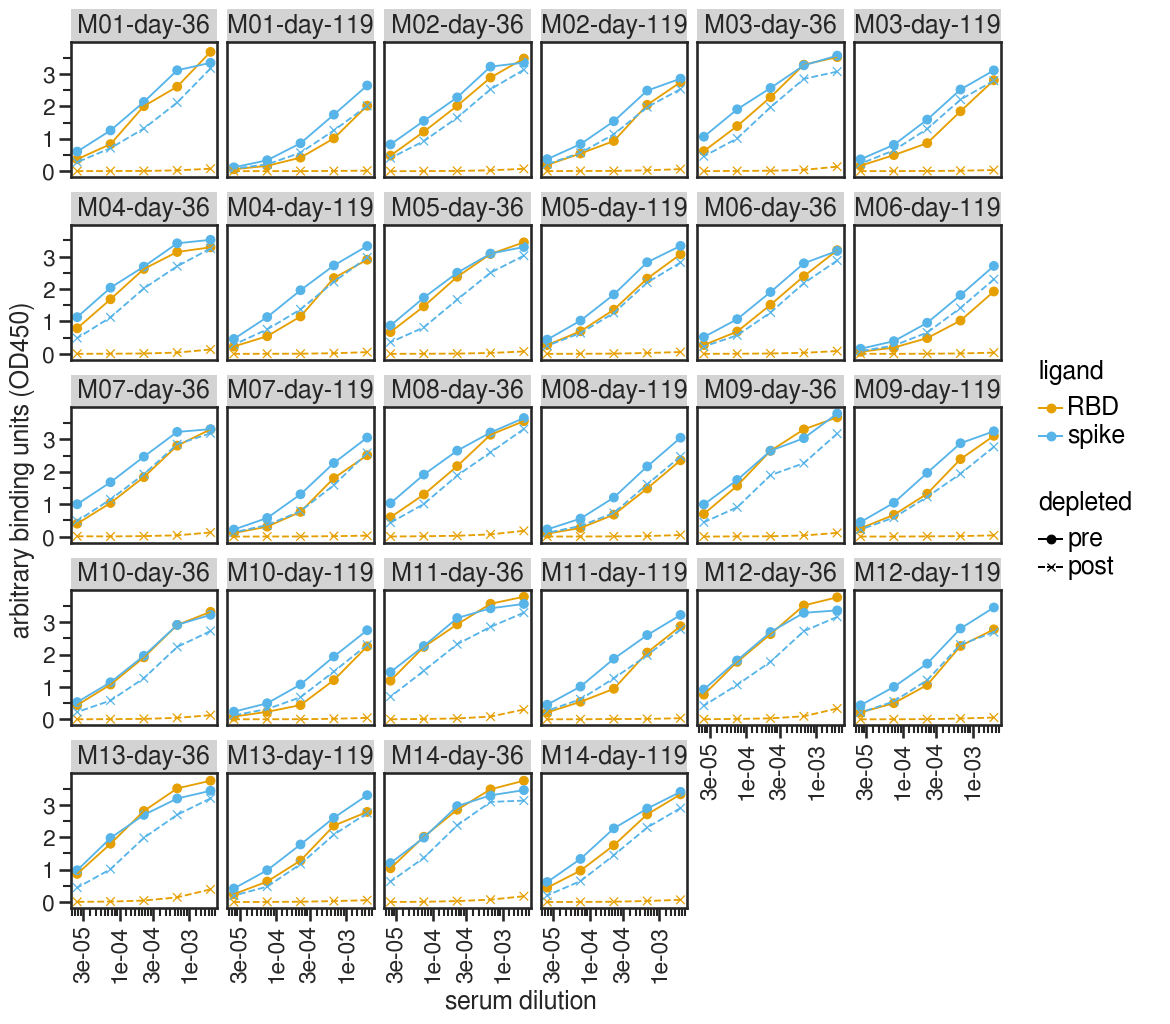

In [19]:
nconditions = df['serum'].nunique()
ncol = np.minimum(6, nconditions)
nrow = math.ceil(nconditions / ncol)

p = (
    ggplot((titration_df
            .assign(serum=lambda x: pd.Categorical(x['serum'], 
                                                   natsort.natsorted(x['serum'].unique()), 
                                                   ordered=True))
#             .sort_values('serum', key=lambda x: np.argsort(natsort.index_natsorted(x)))
           ),
           aes('dilution', 
               'OD450', 
               color='ligand',
               shape='depleted')) +
    geom_point(size=3) +
    geom_path(aes(color='ligand', linetype='depleted'), size=0.75) +
    scale_x_log10(name='serum dilution', labels=scientific_format(digits=0)) +
    facet_wrap('~ serum', ncol=ncol) +
    theme(figure_size=(2 * ncol, 2.25 * nrow),
          axis_text_x=element_text(angle=90),
          subplots_adjust={'hspace':0.35},
#           strip_margin=0.5,
#           strip_background=element_blank()
         ) +
    scale_color_manual(values=CBPALETTE[1:]) +
    scale_shape_manual(values=['o', 'x']) +
    ylab('arbitrary binding units (OD450)')
    )

_ = p.draw()

p.save(f'{resultsdir}/rbd_depletion_elisa.pdf')

### Calculate area under curves (AUCs)
Calculate area under curve (AUC) for each ELISA. Note that these are areas calculated using a trapezoidal rule between the min and max dilutions with the x-axis being the natural log dilution factor.

The utility of these calculations pre-supposes that each sample has the same dilutions.

Merge with HAARVI ELISA data (but remember not comparable!!)

In [20]:
titration_df.head()

,subject,timepoint,serum,depleted,ligand,date,dilution_factor,OD450,dilution
0,M01,36,M01-day-36,pre,RBD,210123,500,3.6820,0.002000
30,M01,36,M01-day-36,post,RBD,210123,500,0.0747,0.002000
60,M01,36,M01-day-36,pre,spike,210205,500,3.3455,0.002000
90,M01,36,M01-day-36,post,spike,210205,500,3.1715,0.002000
120,M01,36,M01-day-36,pre,RBD,210123,1500,2.6068,0.000667


In [21]:
auc_df = (
    titration_df
    .assign(log_dilution=lambda x: np.log(x['dilution']))
    .groupby(['serum',
             'depleted',
             'ligand',
             'date',
             'timepoint',
             ])
    .apply(lambda g: sklearn.metrics.auc(g['log_dilution'], g['OD450']))
    .rename('AUC')
    .reset_index()
    .assign(conv_or_vax='vaccine')
    )

haarvi_elisa = (pd.read_csv(config['convalescent_elisa'])
                [['serum', 'depleted', 'ligand', 'date', 'AUC', 'timepoint']]
                .assign(conv_or_vax='convalescent')
               )

auc_df = (pd.concat([auc_df, haarvi_elisa])
          .assign(depleted=lambda x: pd.Categorical(x['depleted'], categories=['pre', 'post'], ordered=True),
                  conv_or_vax=lambda x: pd.Categorical(x['conv_or_vax'], categories=['vaccine', 'convalescent'], ordered=True),
                 )
         )

auc_df.tail().round(3)
auc_df.to_csv(f'{resultsdir}/elisa_auc.csv', index=False)

Get background (pre-pandemic)

In [22]:
elisa_background_sample = (pd.read_csv(config['elisa_background_file'])
                           .replace('2017-2018 serum pool', 'pre-pandemic')
                           .drop(columns=['dilution_or_ugpermL', 'antibody_ugpermL', 'log_dilution'])
                           .rename(columns={'dilution':'dilution_factor'})
                           .assign(dilution=lambda x: 1/x['dilution_factor'],
                                   log_dilution=lambda x: np.log(x['dilution'])
                                  )
                          )



display(elisa_background_sample.head().head())  # display first few lines

background = (elisa_background_sample
    .groupby(['serum',
             'depleted',
             'ligand',
             'date',
              'replicate',
             ])
    .apply(lambda g: sklearn.metrics.auc(g['log_dilution'], g['OD450']))
    .rename('AUC')
    .reset_index()
              .groupby(['ligand'])
              .aggregate({'AUC' : 'mean'})
              .reset_index()
             )

background

,serum,depleted,ligand,date,dilution_factor,OD450,replicate,dilution,log_dilution
0,pre-pandemic,pre,RBD,201022,100,0.0314,1,0.010000,-4.605170
1,pre-pandemic,pre,RBD,201022,300,0.0082,1,0.003333,-5.703782
2,pre-pandemic,pre,RBD,201022,900,0.0011,1,0.001111,-6.802395
3,pre-pandemic,pre,RBD,201022,2700,-0.0017,1,0.000370,-7.901007
4,pre-pandemic,pre,RBD,201022,8100,-0.0042,1,0.000123,-8.999619


,ligand,AUC
0,RBD,0.041994
1,spike,0.364025


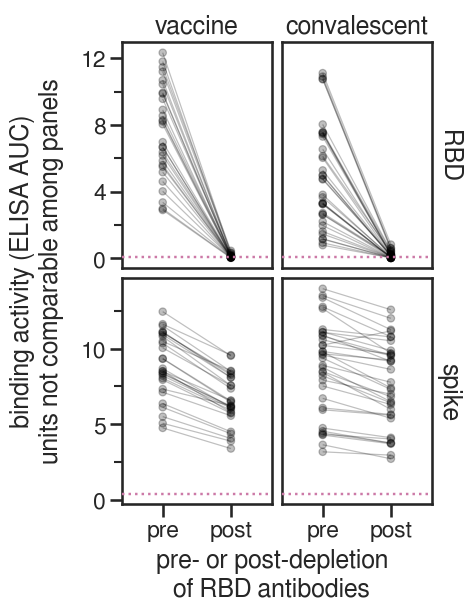

In [23]:
AUC_lines = (ggplot(auc_df
                    .query('serum!="pre-pandemic"'), 
                    aes(x='depleted', y='AUC', group='serum')) +
                  geom_point(size=2.5, alpha=0.25) +
                  geom_line(alpha=0.25) +
                  facet_grid('ligand ~ conv_or_vax ', scales='free_y',) +
                  theme(axis_text_x=element_text(angle=0, vjust=1, hjust=0.5),
                        axis_title_y=element_text(margin={'r': 12}),
                        strip_background=element_blank(),
                        figure_size=(4, 6), #subplots_adjust={'wspace':0.25},
                        legend_entry_spacing=14) +
                  ylab('binding activity (ELISA AUC)\nunits not comparable among panels') +
                  xlab('pre- or post-depletion\nof RBD antibodies') +
             # add line for background defined by 2017-2018 serum pool
                  geom_hline(data=background,
                             mapping=aes(yintercept='AUC'),
                             color=CBPALETTE[7],
                             alpha=1,
                             size=1,
                             linetype='dotted',
                            ) 
                 )

_ = AUC_lines.draw()
AUC_lines.save(f'./{resultsdir}/AUC_lines_compare.pdf')

### Make ELISA plots more similar to the NT50 plots (facet on time point)

In [24]:
auc_df = (auc_df
              .assign(
                      early_late=lambda x: x['timepoint'].apply(lambda x: 'day 30-60' if x<=61 else 'day 100-150'),
                     )
              .assign(early_late=lambda x: pd.Categorical(x['early_late'], categories=['day 30-60', 'day 100-150'], ordered=True),)
             )
display(HTML(auc_df.head().to_html(index=False))) 

serum,depleted,ligand,date,timepoint,AUC,conv_or_vax,early_late
M01-day-119,pre,RBD,210123,119,2.889735,vaccine,day 100-150
M01-day-119,pre,spike,210205,119,4.748092,vaccine,day 100-150
M01-day-119,post,RBD,210123,119,0.016314,vaccine,day 100-150
M01-day-119,post,spike,210205,119,3.382243,vaccine,day 100-150
M01-day-36,pre,RBD,210123,36,8.207787,vaccine,day 30-60


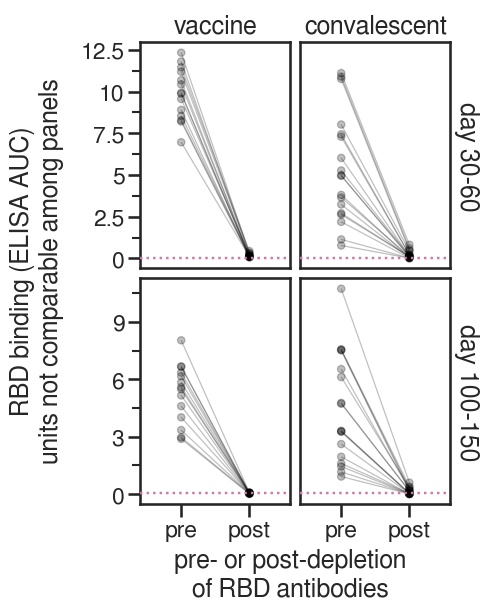

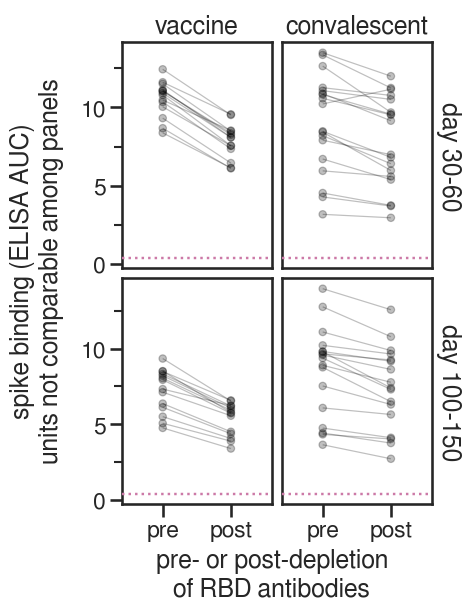

In [25]:
for ligand in ['RBD', 'spike']:
    AUC_facet = (ggplot(auc_df
                        .query('serum!="pre-pandemic" & ligand==@ligand'), 
                        aes(x='depleted', y='AUC', group='serum')) +
                      geom_point(size=2.5, alpha=0.25) +
                      geom_line(alpha=0.25) +
                      facet_grid('early_late ~ conv_or_vax ', scales='free_y',) +
                      theme(axis_text_x=element_text(angle=0, vjust=1, hjust=0.5),
                            axis_title_y=element_text(margin={'r': 12}),
                            strip_background=element_blank(),
                            figure_size=(4, 6), #subplots_adjust={'wspace':0.25},
                            legend_entry_spacing=14) +
                      ylab(f'{ligand} binding (ELISA AUC)\nunits not comparable among panels') +
                      xlab('pre- or post-depletion\nof RBD antibodies') +
                 # add line for background defined by 2017-2018 serum pool
                      geom_hline(data=background.query('ligand==@ligand'),
                                 mapping=aes(yintercept='AUC'),
                                 color=CBPALETTE[7],
                                 alpha=1,
                                 size=1,
                                 linetype='dotted',
                                ) 
                     )

    _ = AUC_facet.draw()
    
    AUC_facet.save(f'./{resultsdir}/{ligand}_AUC_facet.pdf')

In [26]:
!jupyter nbconvert rbd_depletions.ipynb --to markdown

[NbConvertApp] Converting notebook rbd_depletions.ipynb to markdown
[NbConvertApp] Support files will be in rbd_depletions_files/
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Making directory rbd_depletions_files
[NbConvertApp] Writing 35017 bytes to rbd_depletions.md
